# Testes de Significância Estatística Para Avaliar o Impacto do Tipo de Página no Tempo de Execução e Erros de Uma Aplicação Web

## Estudo de Caso em Python

O objetivo deste estudo de caso é realizar testes de significância estatística para analisar o efeito do tipo de página de uma aplicação web no tempo de execução da aplicação e nos erros que ocorrem na aplicação, ou seja, para descobrir se os tipos de página têm um efeito significativo no tempo e no erro. 

São 4 tipos diferentes de página que foram testados em um grupo de usuários e foram anotados seu tempo para usar a página, bem como quaisquer erros durante o uso da página. A realização de testes de significância como ANOVA, MANOVA e Testes T neste conjunto de dados nos ajuda a determinar se o tipo de página tem um efeito significativo e qual tipo de página tem o efeito mais significativo. 

## Hipóteses:
 - H0: As médias em todos os grupos são iguais
 - H1: Ao menos uma das médias é diferente das demais

## Dicionário de Dados:

 - usuario: responsável pelo teste (não é relevante para esta análise).
 - tempo: está em segundos e representa o tempo de acesso para carregar completamente a página.
 - erro: número de erros ao carregar a página
 - pagina: tipo de pagina (principal, login, contato e produtos)


Para mais informações: 

https://www.datascienceacademy.com.br/

https://www.pythonfordatascience.org/anova-python/

In [1]:
# Import dos Pacotes

from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns

# ANOVA
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttost_paired
import pingouin as pg

# MANOVA
from statsmodels.multivariate.manova import MANOVA

%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

# Amostra 1 - Impacto do Tipo de Página no Tempo de Execução

## Import dos Dados 

In [2]:
# Carregando o dataset1 (não precisamos da coluna usuario)
dataset1 = read_csv("dataset1.csv")[['tempo','pagina']]

print(dataset1.shape)

dataset1.head()

(40, 2)


,tempo,pagina
0,2.53,principal
1,2.10,principal
2,3.05,principal
3,2.32,principal
4,2.38,principal


## Análise Exploratória 

In [3]:
# Tipos de dados e resumo estatístico
display(dataset1.info())

display(dataset1.describe())

display(dataset1['pagina'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
tempo     40 non-null float64
pagina    40 non-null object
dtypes: float64(1), object(1)
memory usage: 768.0+ bytes


None

,tempo
count,40.000000
mean,2.551750
std,0.321255
min,1.750000
25%,2.342500
50%,2.620000
75%,2.737500
max,3.150000


login        10
contato      10
produtos     10
principal    10
Name: pagina, dtype: int64

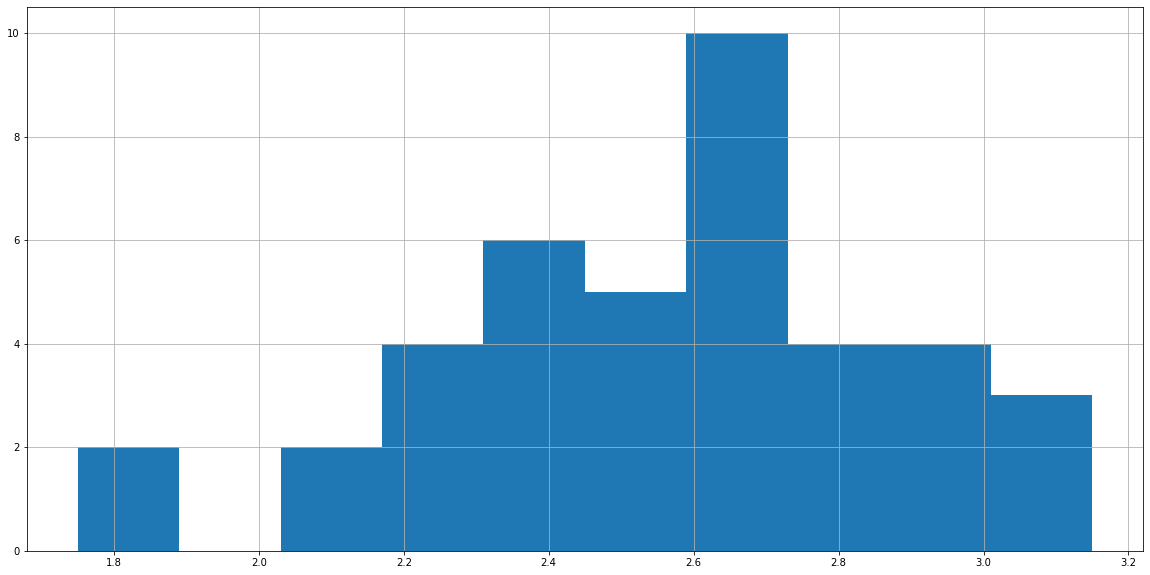

In [4]:
# Histograma da coluna tempo
dataset1['tempo'].hist()

## Análise de Variância (ANOVA)

Determina se as médias de três ou mais grupos são diferentes. A ANOVA usa testes F para testar estatisticamente a igualdade entre médias

In [5]:
# One-Way ANOVA com Scipy.Stats

amostra_login = dataset1[dataset1['pagina'] == 'login']['tempo']
amostra_contato = dataset1[dataset1['pagina'] == 'contato']['tempo']
amostra_principal = dataset1[dataset1['pagina'] == 'principal']['tempo']
amostra_produtos = dataset1[dataset1['pagina'] == 'produtos']['tempo']


resultado_anova = stats.f_oneway(amostra_login,
                                  amostra_contato,
                                  amostra_principal,
                                  amostra_produtos)
display(resultado_anova)

# Obtendo o Valor-p do teste
resultado_anova[1]

F_onewayResult(statistic=3.454875032397825, pvalue=0.026371650474924298)

0.026371650474924298

In [6]:
# One-Way ANOVA com StatsModels

model_anova = ols('tempo ~ C(pagina)', data=dataset1).fit()
resultado_anova = sm.stats.anova_lm(model_anova, typ=2) # Tipo 2 ANOVA 
display(resultado_anova)

# Obtendo o Valor-p do teste
resultado_anova.loc['C(pagina)', 'PR(>F)']

,sum_sq,df,F,PR(>F)
C(pagina),0.899768,3.0,3.454875,0.026372
Residual,3.125210,36.0,NaN,NaN


0.026371650474924336

In [7]:
# One-Way ANOVA com Pingouin
# https://pingouin-stats.org/generated/pingouin.anova.html

resultado_anova = pg.anova(dv='tempo', between='pagina', data=dataset1, detailed=True)
display(resultado_anova)

# Obtendo o Valor-p do teste
resultado_anova.loc[0, 'p-unc']

,Source,SS,DF,MS,F,p-unc,np2
0,pagina,0.899768,3,0.299923,3.454875,0.026372,0.223546
1,Within,3.125210,36,0.086811,NaN,NaN,NaN


0.026371650474924298

### Conclusão:

- Se valor-p < 0.05: rejeitamos a hipótese nula
- Senão: falhamos em rejeitar a a hipótese nula

O valor-p é menor que 0,05. Portanto, os resultados não ocorreram por variação aleatória e a hipótese nula é rejeitada 

Há um efeito significativo do tipo de página (variável independente) no tempo de acesso (variável dependente).




## Teste-t Pairwise

Outra abordagem para determinar quais grupos em pares são significativamente diferentes após a ANOVA é usar vários testes t seguidos por um dos seguintes testes para lidar com erros familiares: Bonferroni, Dunn-Sidàk, Holm, Hochberg, Benjamini-Hochberg ou Benjamini-Yekutieli. 

no nosso caso vamos utilizar o teste Bonferroni

In [8]:
# Scipy.Stats

# A funcao do Scipy nao aceita valores categoricos/strings, vamos converter para numericos
dataset1['pagina_num'] = dataset1['pagina'].map({'contato':1, 'login': 2, 'principal': 3, 'produtos':4})

stats.ttest_rel(dataset1['tempo'], dataset1['pagina_num'])

Ttest_relResult(statistic=0.30836668293126873, pvalue=0.7594444576639443)

In [9]:
# Pingouin
# https://pingouin-stats.org/generated/pingouin.pairwise_ttests.html

resultados_ttp = pg.pairwise_ttests(dv='tempo', between='pagina', data=dataset1,
                   padjust='bonf') # one-step Bonferroni correction
display(resultados_ttp)

# valor-p < 0.05
resultados_ttp[resultados_ttp['p-corr'] < 0.05]

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,pagina,principal,login,False,True,-1.105767,18.0,two-sided,0.283388,1.000000,bonf,0.608,-0.473619
1,pagina,principal,produtos,False,True,-3.432779,18.0,two-sided,0.002968,0.017808,bonf,12.844,-1.470318
2,pagina,principal,contato,False,True,0.424517,18.0,two-sided,0.676220,1.000000,bonf,0.424,0.181828
3,pagina,login,produtos,False,True,-1.396783,18.0,two-sided,0.179464,1.000000,bonf,0.777,-0.598266
4,pagina,login,contato,False,True,1.314064,18.0,two-sided,0.205326,1.000000,bonf,0.721,0.562836
5,pagina,produtos,contato,False,True,3.075985,18.0,two-sided,0.006512,0.039074,bonf,7.105,1.317497


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
1,pagina,principal,produtos,False,True,-3.432779,18.0,two-sided,0.002968,0.017808,bonf,12.844,-1.470318
5,pagina,produtos,contato,False,True,3.075985,18.0,two-sided,0.006512,0.039074,bonf,7.105,1.317497


### Conclusão:

De acordo com os resultados do teste t, apenas os pares produtos-contato e produtos-principal possuem um valor-p (0.039 e 0.017) < 0.05. 

Todos os outros pares têm um valor-p >= 0,05. 

Isso significa que há diferença estatisticamente significativa nos tempos de acesso entre a página de produtos  e a página de contato e principal, mas não há diferença significativa nos tempos de acesso entre outros pares de páginas. 

Para descobrir qual é o melhor entre o a página de contato e a página de produtos, podemos dar uma olhada nas médias.

## Calculando as médias dentro dos grupos

In [10]:
dataset1.groupby('pagina')['tempo'].mean()

pagina
contato      2.388
login        2.598
principal    2.446
produtos     2.775
Name: tempo, dtype: float64

### Conclusão:

O tempo médio de acesso à página de contato (2.388) é significativamente menor que o tempo médio de acesso da página de produtos (2.775). Portanto, a página de contato é melhor que a página de produtos em termos de tempo de acesso.

Da mesma forma, a pagina principal (2.446) é significativamente melhor que a página de produtos.


## Teste-t Unicaudal Esquerdo (tail = "less")

teste unicaudal a esquerda

In [11]:
# Vamos extrair as observações para dois tipos de páginas
contato = dataset1[dataset1['pagina'] == "contato"]
produtos = dataset1[dataset1['pagina'] == "produtos"]

# Teste-t Unicaudal Esquerdo
resultado_testet = pg.ttest(x=contato['tempo'], y=produtos['tempo'], tail = "less")
resultado_testet

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.075985,18,less,0.003256,"[-inf, -0.17]",1.375622,14.211,0.905309


### Conclusão:

Se valor-p < 0.05: rejeitamos a hipótese nula<br>
Senão: falhamos em rejeitar a a hipótese nula

Como valor-p é menor que 0,05, podemos rejeitar a hipótese nula do teste t unicaudal e concluir que a página de contato tem melhores tempos de acesso que a de produtos, na amostra 1.
 

## Visualização

Text(0, 0.5, 'Tempo')

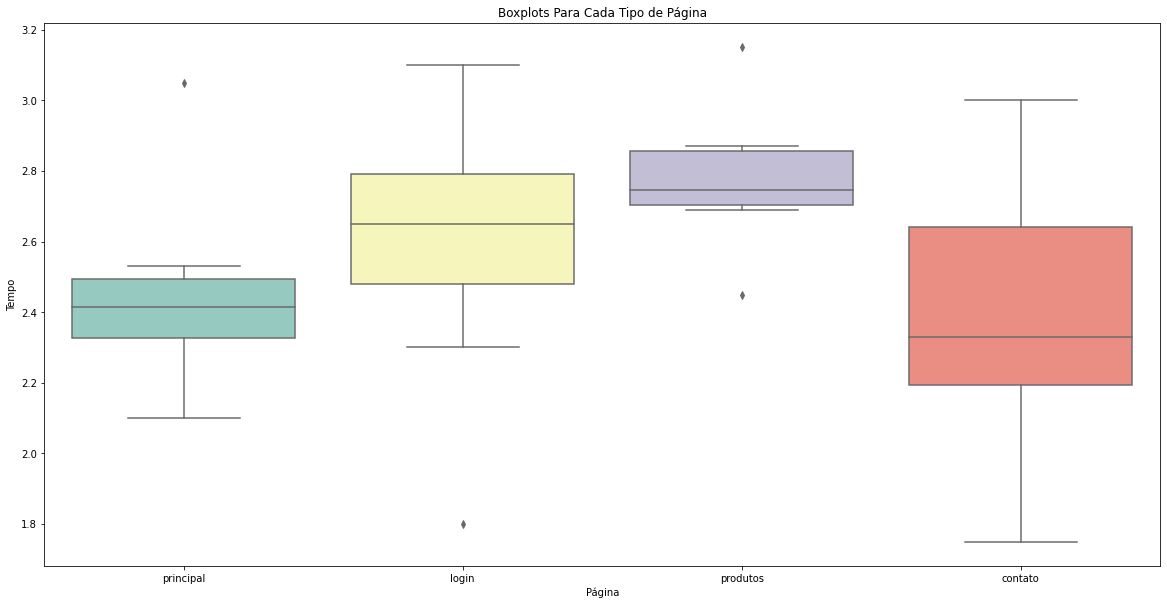

In [12]:
# Boxplot 
sns.boxplot(x = 'pagina', y = 'tempo', data = dataset1, orient='v', palette="Set3")

plt.title("Boxplots Para Cada Tipo de Página")
plt.xlabel("Página")
plt.ylabel("Tempo")

# O Boxplot confirma nossos testes e indica que a pagina de produtos é a mais lenta de todas.

# Amostra 2 - Impacto do Tipo de Página no Erro da Página e no Tempo de Execução

## Import dos Dados 

In [13]:
# Carregando o dataset2 
dataset2 = read_csv("dataset2.csv")

dataset2.head()

,usuario,tempo,erro,pagina
0,1,2.58,2,principal
1,2,2.10,5,principal
2,3,3.05,6,principal
3,4,2.61,6,principal
4,5,2.36,5,principal


## Análise de Variância Multivariada - MANOVA

Utilizada para testar a significancia de diferentes grupos, utilizando mais de 2 variaveis dependentes (geralmente continuas)

In [14]:
# StatsModels

dataset2['pagina_num'] = dataset1['pagina'].map({'contato':1, 'login': 2, 'principal': 3, 'produtos':4})

resultado_manova = MANOVA.from_formula('tempo + erro ~  pagina', data=dataset2)

print(resultado_manova.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0387 2.0000 35.0000 434.7908 0.0000
         Pillai's trace  0.9613 2.0000 35.0000 434.7908 0.0000
 Hotelling-Lawley trace 24.8452 2.0000 35.0000 434.7908 0.0000
    Roy's greatest root 24.8452 2.0000 35.0000 434.7908 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           pagina         Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.4291 6.0000 70.0000  6.1428 0.0000
           Pillai's trace 0.6502 6.0000 72.0000  5.7804 0.0001
   Hotellin

O p-value do Intercepts está ok, temos valores abaixo do que 0.05.

Para essa análise vou utilizar o Pillai's trace como teste estatístico.

Esse teste é considerado o mais poderoso e robusto para uso geral (apesar do Wilks' lambda ser mais popular na literatura), especialmente para desvios de premissas. 

Por exemplo, se a suposição de MANOVA de homogeneidade de covariância da variância for violada, o teste Pillai's trace é a melhor opção. Também é uma boa quando você tem amostras/datasets pequenos.


In [15]:
# valor-p < 0.05
resultado_manova.mv_test().results['pagina']['stat'].values[1, 4]

5.9177262102757005e-05

### Conclusão:

Se valor-p < 0.05: rejeitamos a hipótese nula<br>
Senão: falhamos em rejeitar a a hipótese nula

O valor-p é menor que 0,05. Portanto, os resultados não ocorreram por variação aleatória e a hipótese nula é rejeitada. 

Há um efeito significativo do tipo de página no tempo de acesso e erro na página.



## Aplicando ANOVA ao Resultado da MANOVA

In [16]:
# Vamos descobrir em qual variável dependente (tempo ou erro) a variável independente (pagina) tem efeito
# significante.

# tempo por pagina
resultado_anova1 = pg.anova(dv='tempo', between='pagina', data=dataset2, detailed=True)
print('tempo por pagina')
display(resultado_anova1)

# erro por pagina
resultado_anova2 = pg.anova(dv='erro', between='pagina', data=dataset2, detailed=True)
print('erro por pagina')
display(resultado_anova2)

tempo por pagina


,Source,SS,DF,MS,F,p-unc,np2
0,pagina,0.70187,3,0.233957,2.661589,0.062674,0.181535
1,Within,3.16444,36,0.087901,NaN,NaN,NaN


erro por pagina


,Source,SS,DF,MS,F,p-unc,np2
0,pagina,1644.075,3,548.025,11.399376,0.000021,0.487166
1,Within,1730.700,36,48.075,NaN,NaN,NaN


In [17]:
# Análise do efeito na variável tempo
resultado_anova1.loc[0, 'p-unc']

0.06267377618983135

O valor-p da variável tempo não é menor que 0,05. 

Portanto, o tipo de pagina <b>não</b> afeta significativamente o tempo na amostra 2.

In [18]:
# Análise do efeito na variável erro
resultado_anova2.loc[0, 'p-unc']

2.1085251764900467e-05

O valor-p da variável erro é menor que 0,05. 

Portanto, o tipo de pagina <b>tem</b> efeito significativo no número de erros.

## Teste-t Paiwise Tempo/Pagina

In [19]:
t_test_results = pg.pairwise_ttests(dv='tempo', within='pagina', data=dataset2,
                   padjust='bonf') # one-step Bonferroni correction

display(t_test_results)

# valor-p < 0.05
t_test_results[t_test_results['p-corr'] < 0.05]

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,pagina,principal,login,True,True,1.999091,9.0,two-sided,0.076665,0.459991,bonf,1.281,0.323327
1,pagina,principal,produtos,True,True,-5.389786,9.0,two-sided,0.000439,0.002633,bonf,81.469,-0.996037
2,pagina,principal,contato,True,True,1.158894,9.0,two-sided,0.276323,1.000000,bonf,0.53,0.285334
3,pagina,login,produtos,True,True,-4.426186,9.0,two-sided,0.001656,0.009938,bonf,26.868,-1.093583
4,pagina,login,contato,True,True,-0.199924,9.0,two-sided,0.845985,1.000000,bonf,0.314,-0.042735
5,pagina,produtos,contato,True,True,5.279392,9.0,two-sided,0.000508,0.003045,bonf,72.091,1.089160


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
1,pagina,principal,produtos,True,True,-5.389786,9.0,two-sided,0.000439,0.002633,bonf,81.469,-0.996037
3,pagina,login,produtos,True,True,-4.426186,9.0,two-sided,0.001656,0.009938,bonf,26.868,-1.093583
5,pagina,produtos,contato,True,True,5.279392,9.0,two-sided,0.000508,0.003045,bonf,72.091,1.089160


A pagina de produtos tem relação significativa com todas as outras paginas em relação ao tempo. 

Vamos testar as combinações com um teste unicaudal superior (direito) e qual das paginas é melhor.

## Teste-t Unicaudal Esquerdo (tail = "greater")

In [20]:
# Teste-t Unicaudal Direito (tail = "greater") entre as paginas produtos e contato

# Vamos extrair as observações para dois tipos de páginas
contato = dataset2[dataset2['pagina'] == "contato"]
produtos = dataset2[dataset2['pagina'] == "produtos"]

# Teste-t Unicaudal Esquerdo
resultado_testet1 = pg.ttest(x=produtos['tempo'], y=contato['tempo'], tail = "greater", paired=True)

display(resultado_testet1)

print("Valor-p produtos-contato: {}".format(resultado_testet1['p-val'][0]))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,5.279392,9,greater,0.000254,"[0.21, inf]",1.137211,144.183,0.951926


Valor-p produtos-contato: 0.00025375602581862957


In [21]:
# Teste-t Unicaudal Direito (tail = "greater") entre as paginas produtos e login

# Vamos extrair as observações para dois tipos de páginas
login = dataset2[dataset2['pagina'] == "login"]
produtos = dataset2[dataset2['pagina'] == "produtos"]

# Teste-t Unicaudal Esquerdo
resultado_testet2 = pg.ttest(x=produtos['tempo'], y=login['tempo'], tail = "greater", paired=True)

display(resultado_testet2)


print("Valor-p produtos-login: {}".format(resultado_testet2['p-val'][0]))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.426186,9,greater,0.000828,"[0.19, inf]",1.141829,53.736,0.953244


Valor-p produtos-login: 0.0008281388874318565


In [22]:
# Teste-t Unicaudal Direito (tail = "greater") entre as paginas produtos e principal

# Vamos extrair as observações para dois tipos de páginas
principal = dataset2[dataset2['pagina'] == "principal"]
produtos = dataset2[dataset2['pagina'] == "produtos"]

# Teste-t Unicaudal Esquerdo
resultado_testet3 = pg.ttest(x=produtos['tempo'], y=principal['tempo'], tail = "greater", paired=True)

display(resultado_testet3)

print("Valor-p produtos-principal: {}".format(resultado_testet3['p-val'][0]))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,5.389786,9,greater,0.000219,"[0.15, inf]",1.03998,162.939,0.91668


Valor-p produtos-principal: 0.00021941636247249747


Como valor-p é menor que 0,05 em todos os casos, podemos rejeitar a hipótese nula do teste t unicaudal e concluir  que todas as outras páginas tem melhores tempos de acesso que a de produtos.

## Teste-t Paiwise Erro/Pagina

In [23]:
t_test_results = pg.pairwise_ttests(dv='erro', within='pagina', data=dataset2,
                   padjust='bonf') # one-step Bonferroni correction

display(t_test_results)

# valor-p < 0.05
t_test_results[t_test_results['p-corr'] < 0.05]

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,pagina,principal,login,True,True,-5.885047,9.0,two-sided,0.000233,0.001400,bonf,138.871,-2.300862
1,pagina,principal,produtos,True,True,-3.033858,9.0,two-sided,0.014158,0.084948,bonf,4.698,-1.437831
2,pagina,principal,contato,True,True,-7.689717,9.0,two-sided,0.000030,0.000182,bonf,794.164,-3.018507
3,pagina,login,produtos,True,True,1.890510,9.0,two-sided,0.091262,0.547572,bonf,1.128,0.780713
4,pagina,login,contato,True,True,0.000000,9.0,two-sided,1.000000,1.000000,bonf,0.309,0.000000
5,pagina,produtos,contato,True,True,-1.858241,9.0,two-sided,0.096082,0.576493,bonf,1.086,-0.899435


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,pagina,principal,login,True,True,-5.885047,9.0,two-sided,0.000233,0.001400,bonf,138.871,-2.300862
2,pagina,principal,contato,True,True,-7.689717,9.0,two-sided,0.000030,0.000182,bonf,794.164,-3.018507


A pagina principal tem relação significativa com as paginas de contato e login em relação ao erro. 

Vamos testar as combinações com um teste unicaudal inferior (esquerdo) e verificar qual é melhor.

## Teste-t Unicaudal Esquerdo (tail = "less")

In [24]:
# Teste-t Unicaudal Esquerdo (tail = "less") entre as paginas principal e contato

# Vamos extrair as observações para dois tipos de páginas
principal = dataset2[dataset2['pagina'] == "principal"]
contato = dataset2[dataset2['pagina'] == "contato"]

# Teste-t Unicaudal Esquerdo
resultado_testet1 = pg.ttest(x=principal['erro'], y=contato['erro'], tail = "less", paired=True)

display(resultado_testet1)

print("Valor-p principal-contato: {}".format(resultado_testet1['p-val'][0]))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-7.689717,9,less,0.000015,"[-inf, -11.88]",3.151676,1588.328,1.0


Valor-p principal-contato: 1.5159502422683217e-05


Como valor-p é menor que 0,05, rejeitamos a hipótese nula do teste t unicaudal e concluímos que  a página principal apresenta menos erros que a página de contato.

In [25]:
# Teste-t Unicaudal Esquerdo (tail = "less") entre as paginas principal e login

# Vamos extrair as observações para dois tipos de páginas
principal = dataset2[dataset2['pagina'] == "principal"]
login = dataset2[dataset2['pagina'] == "login"]

# Teste-t Unicaudal Esquerdo
resultado_testet2 = pg.ttest(x=principal['erro'], y=login['erro'], tail = "less", paired=True)

display(resultado_testet2)

print("Valor-p principal-login: {}".format(resultado_testet2['p-val'][0]))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-5.885047,9,less,0.000117,"[-inf, -10.74]",2.40237,277.741,1.0


Valor-p principal-login: 0.00011668022941126996


Como valor-p é menor que 0,05, rejeitamos a hipótese nula do teste t unicaudal e concluímos que  a página principal apresenta menos erros que a página de login.

In [26]:
# Teste-t Unicaudal Esquerdo (tail = "less") entre as paginas principal e produtos

# Vamos extrair as observações para dois tipos de páginas
principal = dataset2[dataset2['pagina'] == "principal"]
produtos = dataset2[dataset2['pagina'] == "produtos"]

# Teste-t Unicaudal Esquerdo
resultado_testet3 = pg.ttest(x=principal['erro'], y=produtos['erro'], tail = "less", paired=True)

display(resultado_testet3)

print("Valor-p principal-produtos: {}".format(resultado_testet3['p-val'][0]))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.033858,9,less,0.007079,"[-inf, -3.44]",1.501265,9.396,0.996652


Valor-p principal-produtos: 0.007078981448739572


Como valor-p é menor que 0,05, rejeitamos a hipótese nula do teste t unicaudal e concluímos que  a página principal apresenta menos erros que a página de produtos.

## Visualizações

Text(0, 0.5, 'Tempo')

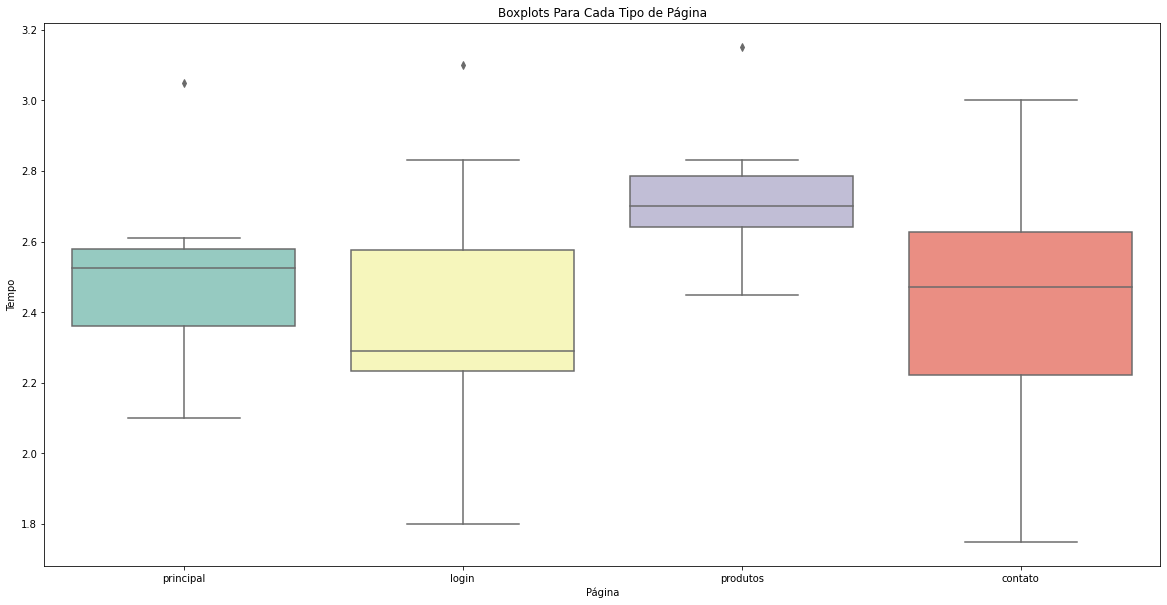

In [27]:
# Boxplot 
sns.boxplot(x = 'pagina', y = 'tempo', data = dataset2, orient='v', palette="Set3")

plt.title("Boxplots Para Cada Tipo de Página")
plt.xlabel("Página")
plt.ylabel("Tempo")


De acordo com o Boxplot acima, percebemos que a pagina de produtos é a que leva mais tempo para carregar.

Portanto, essa página deve ser revisada para reduzir o tempo de carregamento. O resultado foi o mesmo nas duas amostras.

Text(0, 0.5, 'Erro')

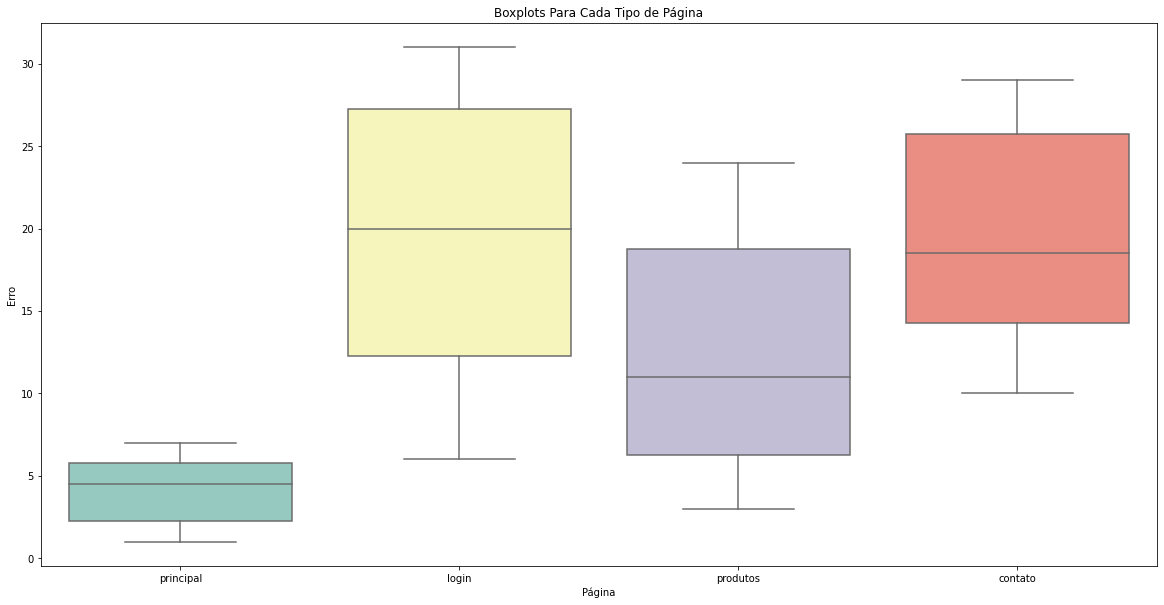

In [28]:
# Boxplot 
sns.boxplot(x = 'pagina', y = 'erro', data = dataset2, orient='v', palette="Set3")

plt.title("Boxplots Para Cada Tipo de Página")
plt.xlabel("Página")
plt.ylabel("Erro")


De acordo com o Boxplot acima, a pagina principal é a que apresenta menor número de erros.

A pagina de login é a que apresenta mais erros (provavelmente por conta de senha errada, por exemplo).